train unzipped.
test unzipped.
submission unzipped.

=== LightGBM Only ===

----- Fold 1/5 -----
[LightGBM] [Info] Number of positive: 68533, number of negative: 131467
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040986 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7939
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.342665 -> initscore=-0.651440
[LightGBM] [Info] Start training from score -0.651440
Training until validation scores don't improve for 50 rounds
[100]	valid_0's auc: 0.895618	valid_0's binary_logloss: 0.445482
[200]	valid_0's auc: 0.900441	valid_0's binary_logloss: 0.393467
[300]	valid_0's auc: 0.904105	valid_0's binary_logloss: 0.374218
[400]	valid_0's auc: 0.906712	valid_0's binary_logloss: 0.365105
[500]	valid_0's auc: 0.90825	valid_0's binary_logloss: 0.360495
[600]	valid_0's auc: 0

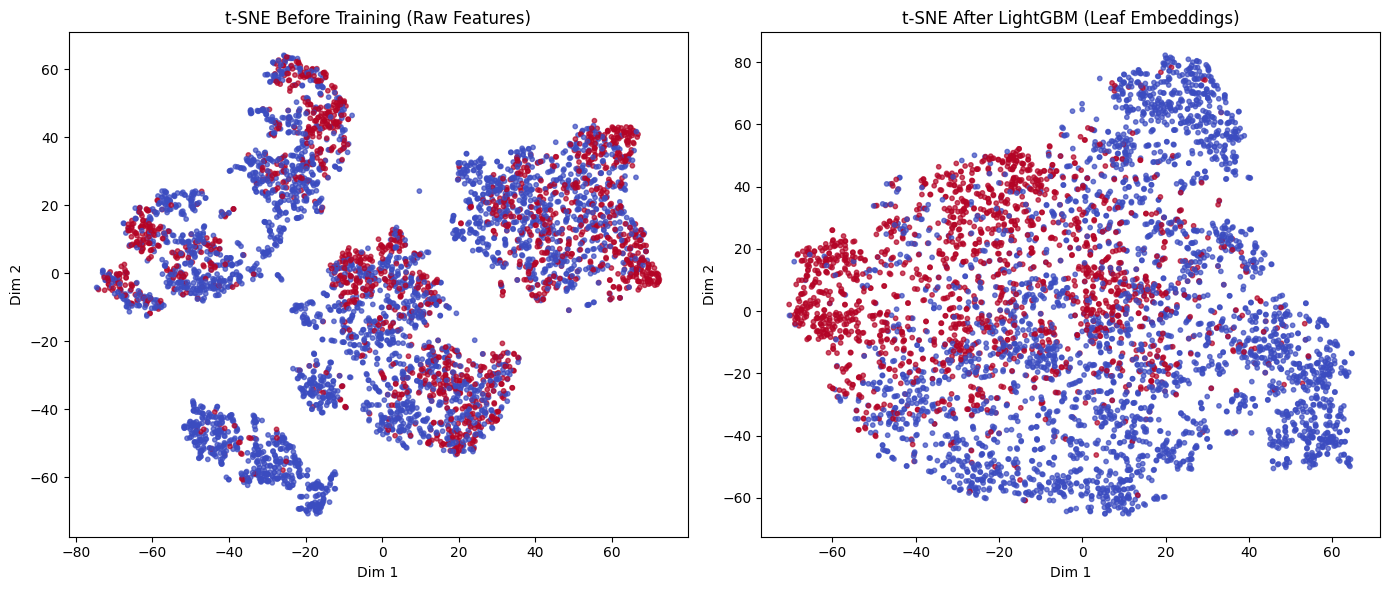


Writing submission...
Saved submission to: /kaggle/working/submission.csv
Final LGBM AMS: 3.60054866353894


In [3]:
# ===============================================================
# HIGGS BOSON — LightGBM Only + t-SNE Visualization (Before vs After)
# ===============================================================

import os, math, zipfile
import numpy as np
import pandas as pd
import random
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# ---------------- Settings ----------------
DEVICE = 'cuda'
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
N_FOLDS = 5

# ---------------- Kaggle File Handling ----------------
zip_files = {
    "train": "/kaggle/input/higgs-boson/training.zip",
    "test":  "/kaggle/input/higgs-boson/test.zip",
    "submission": "/kaggle/input/higgs-boson/random_submission.zip"
}
extract_dir = "/kaggle/working/higgs_data/"
os.makedirs(extract_dir, exist_ok=True)
for key, path in zip_files.items():
    if os.path.exists(path):
        with zipfile.ZipFile(path, "r") as z:
            z.extractall(extract_dir)
            print(f"{key} unzipped.")
    else:
        print(f"{key} zip not found at {path}")

TRAIN_CSV = os.path.join(extract_dir, "training.csv")
TEST_CSV  = os.path.join(extract_dir, "test.csv")
OUT_SUB  = "/kaggle/working/submission.csv"

# ---------------- AMS Metric ----------------
def ams_score(s, b):
    b_reg = 10.0
    rad = 2.0 * ((s + b + b_reg) * math.log(1.0 + s / (b + b_reg)) - s)
    return math.sqrt(rad) if rad > 0 else 0.0

# ---------------- Load Data ----------------
train_df = pd.read_csv(TRAIN_CSV)
test_df  = pd.read_csv(TEST_CSV)

train_df.replace(-999.0, np.nan, inplace=True)
test_df.replace(-999.0, np.nan, inplace=True)

for c in train_df.columns:
    if c in ['EventId','Weight','Label']: continue
    if train_df[c].isna().any():
        train_df[c+'_miss'] = train_df[c].isna().astype(int)
        test_df[c+'_miss']  = test_df[c].isna().astype(int)

numeric_cols = [c for c in train_df.select_dtypes(include=np.number).columns if c != "Weight"]
train_df[numeric_cols] = train_df[numeric_cols].fillna(train_df[numeric_cols].median())
num_cols_test = [c for c in numeric_cols if c in test_df.columns]
test_df[num_cols_test] = test_df[num_cols_test].fillna(train_df[num_cols_test].median())

# Add derived features
if {'DER_mass_MMC','DER_mass_vis'}.issubset(train_df.columns):
    train_df['mass_ratio'] = train_df['DER_mass_MMC']/(train_df['DER_mass_vis']+1e-6)
    test_df['mass_ratio']  = test_df['DER_mass_MMC']/(test_df['DER_mass_vis']+1e-6)
if {'PRI_tau_pt','PRI_met'}.issubset(train_df.columns):
    train_df['pt_ratio'] = train_df['PRI_tau_pt']/(train_df['PRI_met']+1e-6)
    test_df['pt_ratio']  = test_df['PRI_tau_pt']/(test_df['PRI_met']+1e-6)

y = (train_df['Label'] == 's').astype(int).values
weights = train_df['Weight'].values
event_ids_test = test_df['EventId'].values

train_features = train_df.drop(columns=['EventId','Weight','Label'], errors='ignore')
test_features  = test_df.drop(columns=['EventId'], errors='ignore')

scaler = StandardScaler()
X = scaler.fit_transform(train_features.values.astype(np.float32))
X_test = scaler.transform(test_features.values.astype(np.float32))

kf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

# ---------------- LightGBM Only ----------------
print("\n=== LightGBM Only ===")
oof_lgb = np.zeros(len(X))
test_pred_lgb_folds = []
models = []

for fold, (tr, va) in enumerate(kf.split(X, y)):
    print(f"\n----- Fold {fold+1}/{N_FOLDS} -----")
    lgbm = lgb.LGBMClassifier(
        n_estimators=1200,
        learning_rate=0.01,
        num_leaves=64,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=SEED + fold
    )
    lgbm.fit(
        X[tr], y[tr],
        eval_set=[(X[va], y[va])],
        eval_metric='auc',
        callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(100)]
    )
    val_pred = lgbm.predict_proba(X[va])[:, 1]
    fold_auc = roc_auc_score(y[va], val_pred)
    print(f"Fold {fold+1} AUC: {fold_auc:.4f}")

    oof_lgb[va] = val_pred
    test_pred_lgb_folds.append(lgbm.predict_proba(X_test)[:, 1])
    models.append(lgbm)

test_pred_lgb = np.mean(test_pred_lgb_folds, axis=0)
cv_auc = roc_auc_score(y, oof_lgb)
print(f"\nOverall CV AUC: {cv_auc:.4f}")

# ---------------- AMS ----------------
thr_range = np.linspace(0.01, 0.99, 99)
best_thr, best_ams = 0.5, -1
for t in thr_range:
    s = weights[(y == 1) & (oof_lgb > t)].sum()
    b = weights[(y == 0) & (oof_lgb > t)].sum()
    sc = ams_score(s, b)
    if sc > best_ams:
        best_ams, best_thr = sc, t
print(f"Best AMS on LGBM OOF = {best_ams:.3f} @ thr={best_thr:.4f}")

# ---------------- t-SNE Visualization ----------------
print("\nGenerating t-SNE visualizations...")

# Sample subset for visualization (too large dataset otherwise)
max_samples = 5000
idx_sample = np.random.choice(len(X), size=min(max_samples, len(X)), replace=False)
X_sample = X[idx_sample]
y_sample = y[idx_sample]

# Before training (original feature space)
print("Running t-SNE on original features...")
tsne_before = TSNE(n_components=2, random_state=SEED, perplexity=30, n_iter=1000)
emb_before = tsne_before.fit_transform(X_sample)

# After training (use LightGBM leaf embeddings)
print("Generating LightGBM leaf embeddings...")
leaf_indices = models[0].predict(X_sample, pred_leaf=True)
# If ensemble, concatenate leaves from multiple models
for m in models[1:]:
    leaf_indices = np.hstack([leaf_indices, m.predict(X_sample, pred_leaf=True)])
print("Running t-SNE on LightGBM leaf embeddings...")
tsne_after = TSNE(n_components=2, random_state=SEED, perplexity=30, n_iter=1000)
emb_after = tsne_after.fit_transform(leaf_indices)

# Plot before vs after
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
axs[0].scatter(emb_before[:, 0], emb_before[:, 1], c=y_sample, cmap='coolwarm', s=10, alpha=0.7)
axs[0].set_title("t-SNE Before Training (Raw Features)")
axs[0].set_xlabel("Dim 1")
axs[0].set_ylabel("Dim 2")

axs[1].scatter(emb_after[:, 0], emb_after[:, 1], c=y_sample, cmap='coolwarm', s=10, alpha=0.7)
axs[1].set_title("t-SNE After LightGBM (Leaf Embeddings)")
axs[1].set_xlabel("Dim 1")
axs[1].set_ylabel("Dim 2")

plt.tight_layout()
plt.show()

# ---------------- Submission ----------------
print("\nWriting submission...")
rankorder = np.argsort(np.argsort(test_pred_lgb)) + 1
classes = np.where(test_pred_lgb > best_thr, 's', 'b')
sub = pd.DataFrame({"EventId": event_ids_test, "RankOrder": rankorder, "Class": classes})
sub.to_csv(OUT_SUB, index=False)
print("Saved submission to:", OUT_SUB)
print("Final LGBM AMS:", best_ams)
